In [3]:
import torch, torchvision
from torchvision import datasets
import torchvision.transforms as tf
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision.datasets import FashionMNIST

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [2]:
training_data = datasets.FashionMNIST(root='./data',
                                      train=True,
                                      download=True,
                                      transform=tf.ToTensor(),
                                      target_transform=None)

100%|██████████| 26.4M/26.4M [00:08<00:00, 3.22MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 296kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.43MB/s]
100%|██████████| 5.15k/5.15k [00:00<?, ?B/s]


In [4]:
def calculate_mean_std(dataset, batch_size: int = 10):
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    mean = 0.
    std = 0.
    nb_samples = 0.
    for data, label in loader:
        batch_samples = data.size(0)
        data = data.view(batch_samples, data.size(1), -1)
        mean += data.mean(2).sum(0)
        std += data.std(2).sum(0)
        nb_samples += batch_samples

    mean /= nb_samples
    std /= nb_samples
    return mean, std

In [5]:
mean, std = calculate_mean_std(training_data)
mean, std

(tensor([0.2860]), tensor([0.3205]))

In [7]:
normalized_tf = tf.Compose([
    tf.ToTensor(),
    tf.Normalize(mean.tolist(), std.tolist())
])

In [6]:
training_data.transform = tf.Compose([
    tf.ToTensor(),
    tf.Normalize(mean.tolist(), std.tolist())
])

In [8]:
testing_data = datasets.FashionMNIST(root='./data',
                                     train=False,
                                     download=True,
                                     transform=normalized_tf,
                                     target_transform=None)

In [11]:
def img_show(img_tensor: torch.Tensor, label, mean, std, device: device):
    """
    Unnormalize and show a tensor image.
    img_tensor: Tensor image of shape [C, H, W]
    mean, std: Lists of mean and std used during normalization
    """
    # Clone to avoid modifying original
    img = img_tensor.clone().to(device)

    for channel in range(img_tensor.size(0)):
        img[channel] = img[channel] * std[channel] + mean[channel]

    npimg = img.permute(1,2,0).detach().numpy()
    if img.shape[0] == 1:  # grayscale
        npimg = npimg.squeeze()
        plt.imshow(npimg, cmap='gray')
    else:
        plt.imshow(npimg)
    plt.title(label)

In [12]:
class_name = training_data.classes
len(class_name), class_name

(10,
 ['T-shirt/top',
  'Trouser',
  'Pullover',
  'Dress',
  'Coat',
  'Sandal',
  'Shirt',
  'Sneaker',
  'Bag',
  'Ankle boot'])

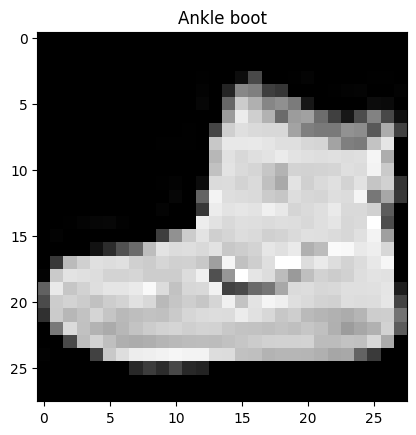

In [13]:
img_show(training_data[0][0], class_name[training_data[0][1]], mean, std, device)

In [14]:
import torch.nn as nn

In [15]:
class CNNFashionMNIST(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(CNNFashionMNIST, self).__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_size,
                      out_channels=hidden_size,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_size,
                      out_channels=hidden_size,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_size,
                      out_channels=hidden_size,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_size,
                      out_channels=hidden_size,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_size * 7 * 7, out_features=output_size),
        )

    def forward(self, x: torch.Tensor):
        x = self.conv_block_1(x)
        print(x.shape)
        x = self.conv_block_2(x)
        print(x.shape)
        # x = self.classifier(self.conv_block_2(self.conv_block_1(x)))
        return self.classifier(x)

In [16]:
input_sample, label_sample = next(iter(training_data))

In [17]:
input_sample.shape

torch.Size([1, 28, 28])

In [18]:
torch.manual_seed(42)
model = CNNFashionMNIST(input_size=1, hidden_size=64, output_size=10)

In [20]:
model(input_sample.unsqueeze(0))

torch.Size([1, 64, 14, 14])
torch.Size([1, 64, 7, 7])


tensor([[-0.0404,  0.0152, -0.0153,  0.0071,  0.0580,  0.0051, -0.0144, -0.0139,
         -0.1156,  0.0367]], grad_fn=<AddmmBackward0>)